In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class MnistDataSet(torch.utils.data.Dataset):
    def __init__(self):
        mnist_train = datasets.MNIST(root='./mnist_data/', train=True, download=True)
        self.data = mnist_train.data.reshape(-1, 1, 28, 28).float() / 255.0
        self.data = 1 * (self.data > 0.5)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

dataset = MnistDataSet()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Tue Jan 12 11:27:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    13W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
def norm(t, dim):
    return torch.sqrt(torch.sum(t * t, dim))


def normalize_weight_jit(log_w_norm, w):
    return torch.exp(log_w_norm) * w / (norm(w, dim=[1,2,3]).view(-1, 1, 1, 1) + 1e-5)
    


class WnConv2d(nn.Module):
    def __init__(self, c_in, c_out, kernel_size, stride=1, padding=0, bias=False):
        super().__init__()
        self.weight = torch.randn(c_out, c_in, kernel_size[0], kernel_size[1])
        torch.nn.init.xavier_uniform_(self.weight)
        self.weight = nn.Parameter(self.weight, requires_grad=True)
        self.bias = torch.zeros((c_out), requires_grad=True)
        self.stride = stride
        self.padding = padding
        init = norm(self.weight, dim=[1, 2, 3]).view(-1, 1, 1, 1)
        self.log_weight_norm = nn.Parameter(torch.log(init + 1e-2), requires_grad=True)
        self.init_done = False
        self.weight_normalized = self.normalize_weight()

    def forward(self, x):
        if not self.init_done:
            with torch.no_grad():
                weight = self.weight / (norm(self.weight, dim=[1, 2, 3]).view(-1, 1, 1, 1) + 1e-5)
                bias = None
                out = F.conv2d(x, weight, bias, self.stride, self.padding)
                mn = torch.mean(out, dim=[0, 2, 3])
                st = 5 * torch.std(out, dim=[0, 2, 3])
                if self.bias is not None:
                    self.bias.data = - mn / (st + 1e-5)
                self.log_weight_norm.data = -torch.log((st.view(-1, 1, 1, 1) + 1e-5))
                self.init_done = True
        self.weight_normalized = self.normalize_weight()
        bias = self.bias
        return F.conv2d(x, self.weight_normalized, bias, 1, self.padding)

    def normalize_weight(self):
        return normalize_weight_jit(self.log_weight_norm, self.weight)



In [3]:
class CausalConvA(nn.Module):
    def __init__(self, cin, cout, vertical_kernel_size, horizontal_kernel_size):
        super().__init__()
        vk_h, vk_w = vertical_kernel_size
        hk_h, hk_w = horizontal_kernel_size
        self.v_conv = WnConv2d(cin, cout, (vk_h, vk_w), stride=1, padding=0, bias=True)
        self.h_conv = WnConv2d(cin, cout, (hk_h, hk_w), stride=1, padding=0, bias=True)
        self.v_pad = (vk_w // 2, vk_w // 2, vk_h, 0)
        self.h_pad = (hk_w, 0, hk_h - 1, 0)
        if vk_w % 2 == 0:
            self.v_pad[1] = self.v_pad[1] - 1

    def forward(self, x):
        v_out = self.v_conv(F.pad(x, pad=self.v_pad))[:, :, :-1, :]
        h_out = self.h_conv(F.pad(x, pad=self.h_pad))[:, :, :, :-1]
        return v_out + h_out


class CausalConvB(nn.Module):
    def __init__(self, cin, cout, kernel_size):
        super().__init__()
        k_h, k_w = kernel_size
        self.conv = WnConv2d(cin, cout, (k_h, k_w), stride=1, padding=0, bias=True)
        self.pad = (k_w - 1, 0, k_h - 1, 0)

    def forward(self, x):
        return self.conv(F.pad(x, pad=self.pad))

In [4]:
class GatedResBlock(nn.Module):
    def __init__(self, cin, c_hid, kernel_size, dropout=0.1, c_aux=0, cond_dim=0):
        super().__init__()
        self.conv1 = CausalConvB(cin, c_hid, kernel_size)
        self.dropout = nn.Dropout(dropout)
        self.conv2 = CausalConvB(c_hid, cin * 2, kernel_size)
        self.gate = nn.GLU(1) 
        self.aux_conv = WnConv2d(c_aux, c_hid, (1, 1), stride=1, padding=0, bias=True) if c_aux > 0 else None
        self.cond_conv = WnConv2d(cond_dim, cin * 2, (1, 1), stride=1, padding=0, bias=True) if cond_dim > 0 else None        

    def forward(self, input, aux_input=None, condition=None):
        out = self.conv1(F.elu(input))
        out = out + F.elu(self.aux_conv(aux_input)) if aux_input is not None else out
        out = self.conv2(self.dropout(F.elu(out)))
        out = out + self.cond_conv(condition) if condition is not None else out
        return self.gate(out) + input

In [5]:
def causal_mask_a_(n_h, n_w):
    len = n_h * n_w
    mask = np.array([[True if j >= i else False for j in range(len)] for i in range(len)], np.bool)
    mask[0][0] = False # first pixel see itself to avoid all attention logits become -inf  
    return torch.from_numpy(mask).to(device) 

def causal_mask_b(n_h, n_w):
    len = n_h * n_w
    mask = np.array([[True if j > i else False for j in range(len)] for i in range(len)], np.bool)
    return torch.from_numpy(mask).to(device)




class CausalAttention(nn.Module): #multi head 
    def __init__(self, c_query, c_key, c_out, n_head=4, dropout=0.1):
        super().__init__()
        self.query = WnConv2d(c_query, c_out, (1, 1), stride=1, padding=0, bias=False)
        self.key = WnConv2d(c_key, c_out, (1, 1), stride=1, padding=0, bias=False)
        self.value = WnConv2d(c_key, c_out, (1, 1), stride=1, padding=0, bias=False)
        self.dim_head = c_out // n_head
        self.n_head = n_head
        self.c_out = c_out
        self.drop = nn.Dropout(dropout)

    def forward(self, q, k):
        n_b, _, n_h, n_w = k.shape
        query = self.query(q).view(n_b, self.n_head, self.dim_head, n_h * n_w)
        value = self.value(k).view(n_b, self.n_head, self.dim_head, n_h * n_w)
        key =   self.key(k).view(n_b, self.n_head, self.dim_head, n_h * n_w)

        query = query.transpose(2, 3) / np.sqrt(self.dim_head)
        value = value.transpose(2, 3)

        attn = torch.matmul(query, key)
        mask = causal_mask_a_(n_h, n_w) # mask a shows better result
        attn = attn.masked_fill(mask, -np.inf)
        attn = torch.softmax(attn, dim=-1)
        attn = self.drop(attn)
        out = attn @ value
        out = out.transpose(1, 2).reshape(n_b, n_h, n_w, self.dim_head * self.n_head)
        out = out.permute(0, 3, 1, 2).contiguous()
        return out



In [13]:
class PixelResBlock(nn.Module):
    def __init__(self, c_in, c_hid, kernel_size, n_res_block, dropout=0.1, cond_dim=0):
        
        super().__init__()
        self.resblocks = nn.ModuleList([
            GatedResBlock(c_in, c_hid, kernel_size, dropout=dropout, c_aux=0, cond_dim=cond_dim) for _ in range(n_res_block)                                        
        ])
        self.key_resblock = GatedResBlock(c_in * 2 + 2, c_in, (1, 1), dropout=dropout, c_aux=0, cond_dim=0)
        self.query_resblock = GatedResBlock(c_in + 2, c_in, (1, 1), dropout=dropout, c_aux=0, cond_dim=0)
        self.out_resblock = GatedResBlock(c_in, c_in, (1, 1), dropout=dropout, c_aux=c_in//2, cond_dim=0)
        self.causal_attention = CausalAttention(c_query=c_in + 2, c_key=c_in * 2 + 2, c_out=(c_in // 2), dropout=dropout)


    def forward(self, input, background=None, condition=None):
        out = input
        for resblock in self.resblocks:
            out = resblock(input=input, aux_input=None, condition=condition)
        key = self.key_resblock(torch.cat([input, out, background], 1)) #c_in + c_in + 2
        query = self.query_resblock(torch.cat([out, background], 1)) #c_out + 2
        attn_out = self.causal_attention(query, key)
        out = self.out_resblock(out, attn_out)
        return out


In [14]:
class PixelSNAIL(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_shape = (1, 28, 28) 
        
        self.causal_conv = CausalConvA(self.input_shape[0], 64, (2, 1), (1, 3))
        self.blocks = nn.ModuleList([
            PixelResBlock(64, 64, (2, 2), 2) for _ in range(3)       
        ])
        self.out = nn.ModuleList([
            GatedResBlock(64, 64, (2, 2)), 
            WnConv2d(64, 1, (1, 1), 1, 0, False)
        ])

        height, width = self.input_shape[1], self.input_shape[2]
        coord_x = (torch.arange(height).float() - height / 2) / height
        coord_x = coord_x.view(1, 1, height, 1).expand(1, 1, height, width)
        coord_y = (torch.arange(width).float() - width / 2) / width
        coord_y = coord_y.view(1, 1, 1, width).expand(1, 1, height, width)
        self.background = torch.cat([coord_x, coord_y], dim=1).to(device)
        

    def forward(self, x, condition=None):
        x = self.causal_conv(x)
        background = self.background.expand(x.size(0), -1, -1, -1)
        for block in self.blocks:
            x = block(x, background, condition=condition)
        for out in self.out:
            x = out(x)
        return torch.sigmoid(x)

In [15]:
model = PixelSNAIL().to(device)
mbsz = 16
solver = optim.Adam(model.parameters(), lr=1e-4)
loader = DataLoader(dataset=dataset, batch_size=mbsz, shuffle=True, drop_last=True)

In [16]:
num_epochs = 10
NLL = []
for epoch in range(num_epochs):
    NLL.append(0.0)
    for x_q in loader:
        solver.zero_grad()
        x_q = x_q.to(device).float()
        x_p = model(x_q)
        loss = F.binary_cross_entropy(x_p, x_q, reduction='mean') * 784.
        loss.backward()
        solver.step()
        NLL[-1] += loss.item()
    NLL[-1] /= len(loader)
    print(epoch, NLL[-1]/784.)

0 0.11474962985499376
1 0.08824370148327886
2 0.08201021308120417
3 0.07946686520868418
4 0.07808168431366383
5 0.07705071837107341
6 0.0763210041331596
7 0.07573777138327255
8 0.07523199217011328
9 0.07485674189483228


In [19]:
testdataset = datasets.MNIST(root='./mnist_data/', train=False, download=True).data.float() / 255.0
testdataset = 1 * (testdataset > 0.5)

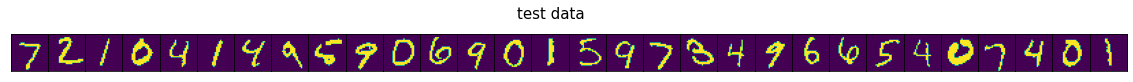

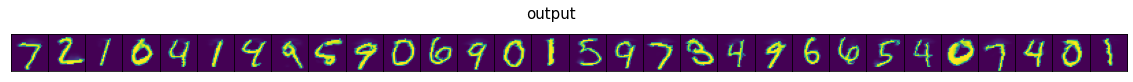

_


<Figure size 1440x144 with 0 Axes>

In [20]:
num_image = 30

fig = plt.figure(figsize=(20, 2))

n = 0
for i in range(num_image):
    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(testdataset[n])
    n += 1
fig.suptitle('test data', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
fig = plt.figure(figsize=(20, 2))

model.eval()
n = 0
for i in range(num_image):
    x_q = testdataset[n].reshape(1, 1, 28, 28).float().to(device)
    x_p = model(x_q)
    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(x_p.cpu().data.numpy().reshape(28, 28))
    n += 1
model.train()
fig.suptitle('output', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
fig = plt.figure(figsize=(20, 2))

model.eval()
print('_')

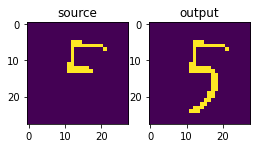

_


In [21]:
f = plt.figure(figsize=(4,2))
ax = f.add_subplot(1,2,1)


input = testdataset[45].reshape(1, 1, 28, 28).float()
input[0, 0, 14:28, :] = 0.0
ax.imshow(input.reshape(28, 28))
ax.set_title('source')

model.eval()
x_q = input.to(device)
with torch.no_grad():
    for h in range(14, 28):
        for w in range(28):
            x_p = model(x_q)
            x_q[0][0][h][w] = 1.0 * (x_p[0][0][h][w] > 0.5) 
            # x_q[0][0][h][w] = x_p[0][0][h][w] 



model.train()


ax = f.add_subplot(1,2,2)
ax.imshow(x_q.cpu().data.numpy().reshape(28, 28))
ax.set_title('output')
plt.show()


print('_')

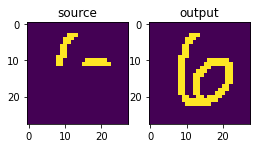

_


In [22]:
f = plt.figure(figsize=(4,2))
ax = f.add_subplot(1,2,1)


input = testdataset[11].reshape(1, 1, 28, 28).float()
input[0, 0, 12:28, :] = 0.0
ax.imshow(input.reshape(28, 28))
ax.set_title('source')

model.eval()
x_q = input.to(device)
with torch.no_grad():
    for h in range(12, 28):
        for w in range(28):
            x_p = model(x_q)
            x_q[0][0][h][w] = 1.0 * (x_p[0][0][h][w] > 0.5) 
            # x_q[0][0][h][w] = x_p[0][0][h][w] 



model.train()


ax = f.add_subplot(1,2,2)
ax.imshow(x_q.cpu().data.numpy().reshape(28, 28))
ax.set_title('output')
plt.show()


print('_')